# ETH-USD Forecast Project

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import ipywidgets
from datetime import datetime, timedelta
import plotly
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.graph_objects as go
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
import itertools
import json
from fbprophet.serialize import model_to_json

sns.set()

### Pull and format Yahoo Finance (Coinmarketcap) data

In [2]:
#Set and format date range for data (as 'close' prices are used, the end date is set to the day before the current date)
start_date = '2016-01-02'
end_date = datetime.today() - timedelta(1)
end_date = datetime.strftime(end_date, '%Y-%m-%d')

In [3]:
#Download data
yf_data = yf.download('ETH-USD',start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [4]:
#Check data types 
yf_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2147 entries, 2016-01-01 to 2021-11-20
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2147 non-null   float64
 1   High       2147 non-null   float64
 2   Low        2147 non-null   float64
 3   Close      2147 non-null   float64
 4   Adj Close  2147 non-null   float64
 5   Volume     2147 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 117.4 KB


In [5]:
#Check for missing 'price' values
yf_data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
#Drop features that aren't required
yf_data = yf_data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis = 1)

In [7]:
#Check for missing 'date' values 
pd.date_range(start = start_date, end = end_date ).difference(yf_data.index)

DatetimeIndex(['2020-04-17', '2020-10-09', '2020-10-12', '2020-10-13',
               '2021-11-21'],
              dtype='datetime64[ns]', freq=None)

In [8]:
#Create new data range that accounts missing dates and 'forward fill' price values
new_date_range = pd.date_range(start = start_date, end = end_date, freq="D")
yf_data = yf_data.reindex(new_date_range, method = 'ffill')

In [9]:
#Confirm that missing 'dates' have been resolved
pd.date_range(start = start_date, end = end_date ).difference(yf_data.index)

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

In [10]:
#Check tail of dataframe
yf_data.tail(10)

Close
2021-11-12  4667.115234
2021-11-13  4651.460449
2021-11-14  4626.358887
2021-11-15  4557.503906
2021-11-16  4216.365234
2021-11-17  4287.593750
2021-11-18  4000.650879
2021-11-19  4298.306641
2021-11-20  4409.931152
2021-11-21  4409.931152

In [11]:
#Prohpet requires a dataframe with 'ds' (datestamp) and 'y' columns. As the date is currently a pandas Datetime index, the index needs to be reset with the dates converted to a feature  
prophet_df = yf_data.reset_index(level = 0)

In [12]:
#Rename features
prophet_df = prophet_df.rename({'index': 'ds', 'Close': 'y'}, axis = 1)
prophet_df

ds            y
0    2016-01-02     0.937124
1    2016-01-03     0.971905
2    2016-01-04     0.954480
3    2016-01-05     0.950176
4    2016-01-06     0.950860
...         ...          ...
2146 2021-11-17  4287.593750
2147 2021-11-18  4000.650879
2148 2021-11-19  4298.306641
2149 2021-11-20  4409.931152
2150 2021-11-21  4409.931152

[2151 rows x 2 columns]

### Create baseline model

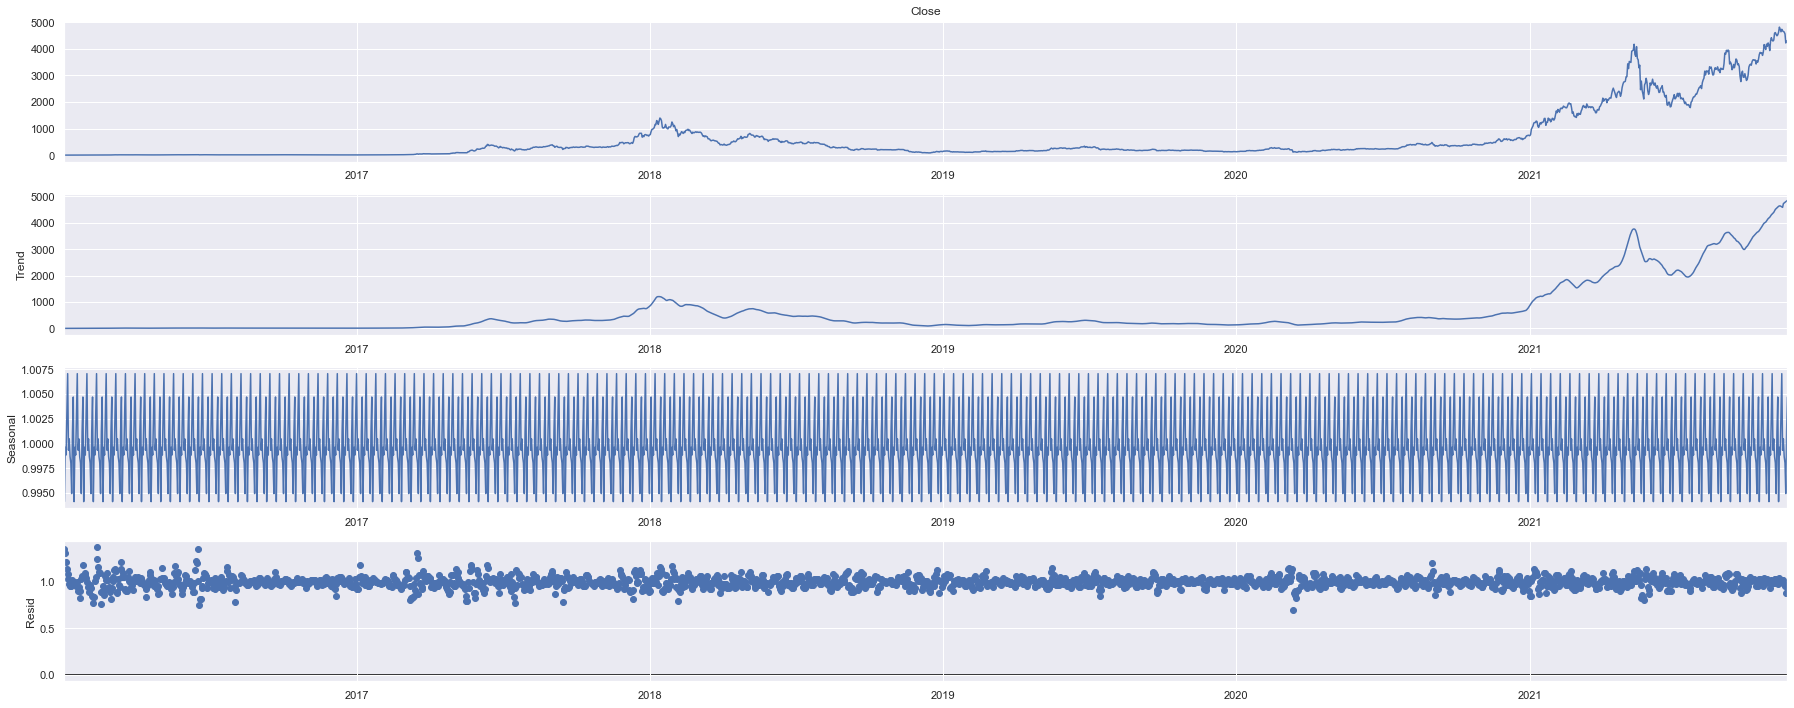

In [46]:
#Check seasonal decomposition to confirm that the Prophet algorithm is suitable for modelling
decomp = seasonal_decompose(yf_data['Close'], model = 'multiplicative', extrapolate_trend = 'freq', period = 12)
plt.rcParams.update({'figure.figsize': (25,10)})
decomp.plot()
plt.show()

In [13]:
#Create baseline Prophet model. It is clear from the seasonal decomposition that 'multiplicative' process is probably most suitable. Confidence intervals have also been set to 95%. 
model = Prophet(
    seasonality_mode="multiplicative",
    yearly_seasonality=True,
    interval_width = 0.95
)
model.fit(prophet_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [14]:
#Set a forecast horizon of 60 days
future = model.make_future_dataframe(periods = 60)

In [49]:
#Get predicted values for the forecast horizon and retain needed columns
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds         yhat   yhat_lower   yhat_upper
2203 2022-01-13  4846.302201  4581.498961  5093.964789
2204 2022-01-14  4846.825957  4621.056285  5100.072312
2205 2022-01-15  4863.642070  4595.796341  5106.590607
2206 2022-01-16  4877.918685  4601.494420  5116.879784
2207 2022-01-17  4876.069933  4594.123791  5126.062488

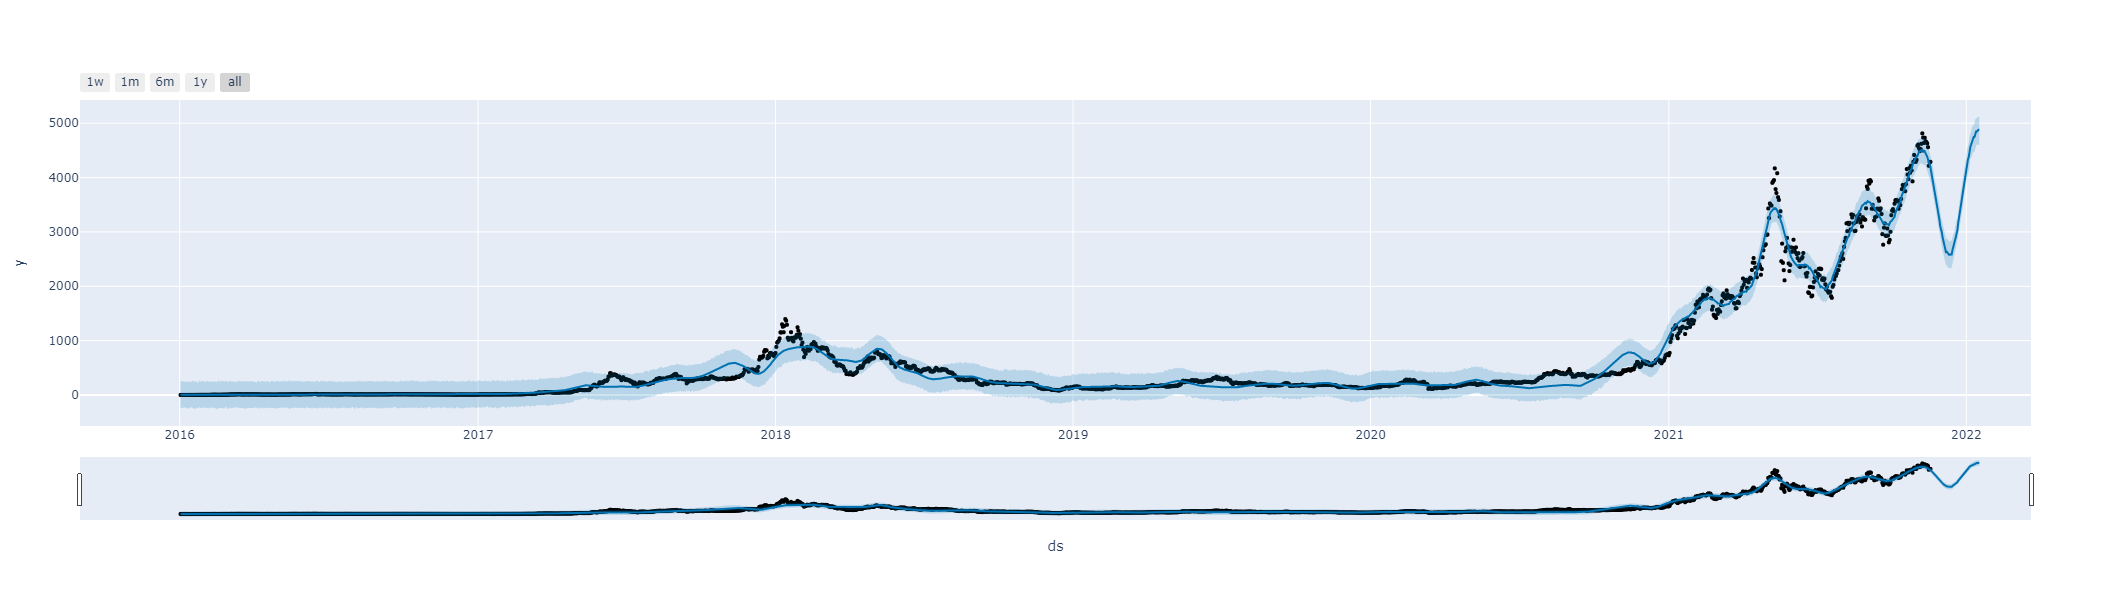

In [50]:
#Use the Prophet library plotly plotting method for visualise the forecast
plot_plotly(model, forecast)

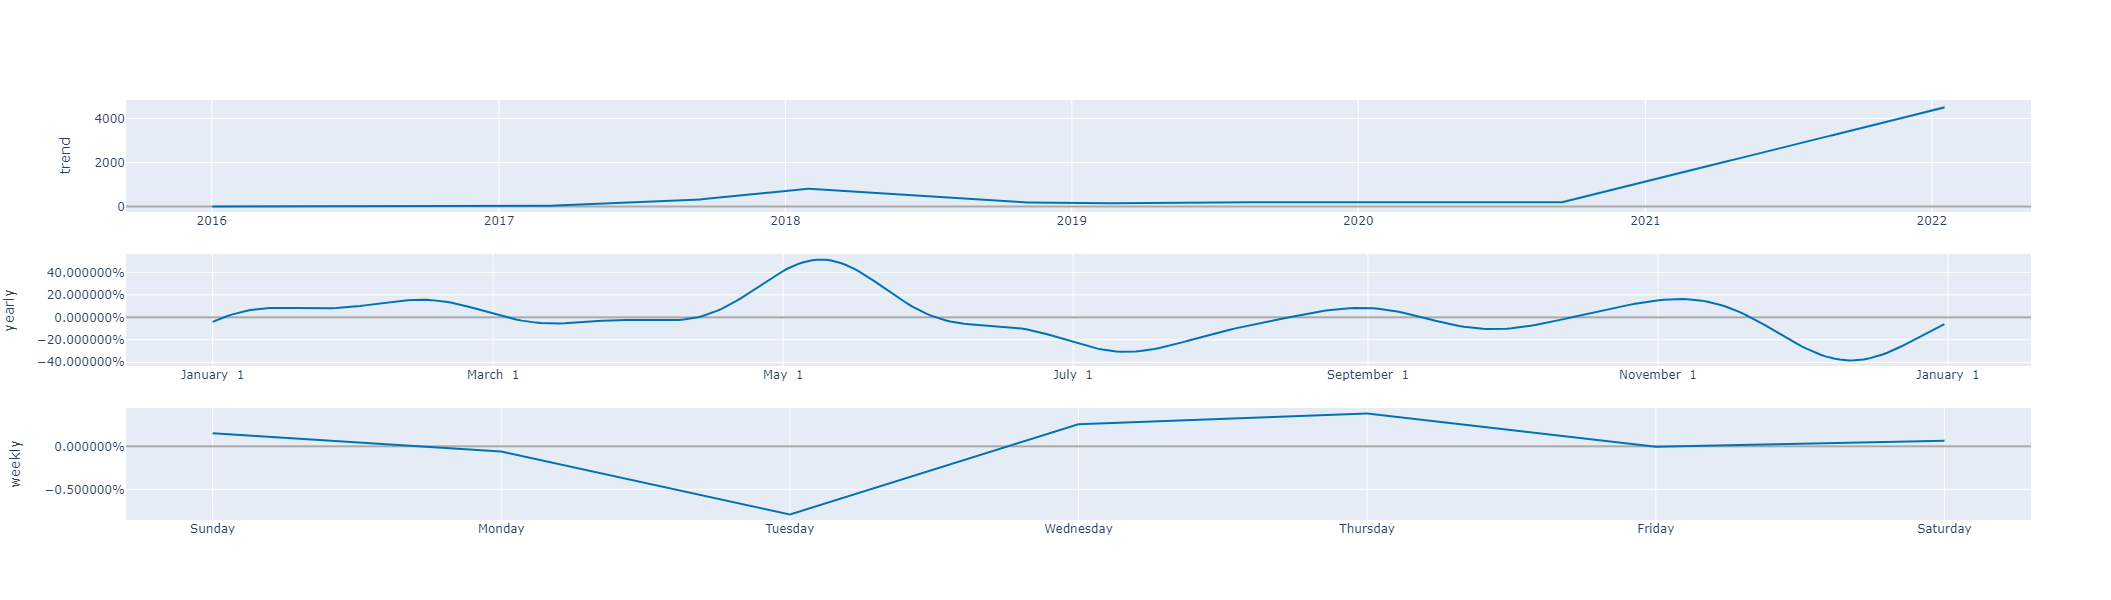

In [51]:
#As Prophet employs an 'additive' modelling process, use the in-build plotting methods to visualise each component modeled 
plot_components_plotly(model, forecast)

### Cross-validate baseline model

In [52]:
#Use the Prophet 'cross-validation' method to perform cross-validation
df_cv = cross_validation(model, initial='730 days', period='30 days', horizon = '60 days')

INFO:fbprophet:Making 46 forecasts with cutoffs between 2018-01-08 00:00:00 and 2021-09-19 00:00:00


  0%|          | 0/46 [00:00<?, ?it/s]

In [53]:
#Check cross-validation results
df_cv.head(10)

ds         yhat   yhat_lower   yhat_upper            y     cutoff
0 2018-01-09  1319.040473  1284.923850  1353.303774  1299.739990 2018-01-08
1 2018-01-10  1427.259847  1390.827220  1461.752304  1255.819946 2018-01-08
2 2018-01-11  1541.295245  1504.023096  1576.475596  1154.930054 2018-01-08
3 2018-01-12  1668.776524  1634.768885  1702.490767  1273.199951 2018-01-08
4 2018-01-13  1815.537881  1781.207678  1850.225909  1396.420044 2018-01-08
5 2018-01-14  1974.433866  1941.891939  2010.218036  1366.770020 2018-01-08
6 2018-01-15  2153.841666  2121.211795  2187.467233  1291.920044 2018-01-08
7 2018-01-16  2356.748244  2322.515973  2392.735511  1053.689941 2018-01-08
8 2018-01-17  2544.941926  2512.105502  2577.654006  1014.250000 2018-01-08
9 2018-01-18  2732.883407  2701.147075  2770.543164  1036.280029 2018-01-08

In [54]:
#Use the Prophet 'performance_metrics' method to get perfromance metrics for the cross-validation results
df_p = performance_metrics(df_cv)

In [55]:
#Check cross-validation performance
df_p

horizon            mse        rmse         mae      mape     mdape  \
0   6 days   28222.406531  167.995257  123.101286  0.305504  0.218136   
1   7 days   36444.858924  190.905366  137.332736  0.323806  0.226147   
2   8 days   50928.672942  225.673820  154.414898  0.343019  0.234594   
3   9 days   70856.621424  266.189071  174.149870  0.362255  0.247720   
4  10 days   94025.953867  306.636518  192.808051  0.380157  0.258305   
5  11 days  126970.315508  356.328943  215.477023  0.397800  0.271930   
6  12 days  170274.677399  412.643523  242.682031  0.414967  0.293173   
7  13 days  218015.284746  466.921069  268.482345  0.430673  0.313563   
8  14 days  271057.417862  520.631749  294.173209  0.445021  0.326928   
9  15 days  324760.505592  569.877623  318.233490  0.460224  0.345867   
10 16 days  386954.285290  622.056497  344.167869  0.474540  0.364037   
11 17 days  447172.976085  668.709934  366.875795  0.489764  0.381584   
12 18 days  495337.491927  703.802168  384.395961  0.505835  0.395468   
13 19 days  543531.632590  737.245978  400.458740  0.520005  0.402868   
14 20 days  576865.241000  759.516452  412.749707  0.533754  0.435500   
15 21 days  604380.142213  777.418898  421.003342  0.544777  0.448387   
16 22 days  632882.157492  795.538910  427.150187  0.557480  0.458330   
17 23 days  653982.564469  808.691885  432.406694  0.569471  0.461056   
18 24 days  676308.377616  822.379704  436.499289  0.578493  0.463673   
19 25 days  694418.269339  833.317628  438.350259  0.590151  0.468997   
20 26 days  717722.948406  847.185309  440.847972  0.600681  0.473714   
21 27 days  733001.314700  856.154960  440.109743  0.612628  0.477943   
22 28 days  736738.573615  858.334768  437.350794  0.625583  0.476743   
23 29 days  732490.495183  855.856586  430.839355  0.632650  0.477943   
24 30 days  727357.167697  852.852372  426.890701  0.642154  0.481127   
25 31 days  708385.731477  841.656540  420.184346  0.647386  0.465049   
26 32 days  678468.100570  823.691751  411.899921  0.651707  0.454660   
27 33 days  655650.166794  809.722278  409.242551  0.655517  0.454257   
28 34 days  630777.638012  794.215108  407.007169  0.656565  0.448854   
29 35 days  603321.322489  776.737615  405.117854  0.659739  0.441961   
30 36 days  573165.726697  757.077094  400.563543  0.662348  0.431040   
31 37 days  547648.131712  740.032521  398.337876  0.664387  0.425084   
32 38 days  524204.125275  724.019423  396.420167  0.664156  0.425306   
33 39 days  504954.468817  710.601484  395.279592  0.661611  0.424672   
34 40 days  485935.375875  697.090651  393.930880  0.657891  0.425306   
35 41 days  481826.011102  694.136882  397.571827  0.656162  0.426375   
36 42 days  487391.094880  698.134009  405.120425  0.652112  0.434394   
37 43 days  501236.623448  707.980666  414.123694  0.647641  0.438397   
38 44 days  532888.674022  729.992242  425.989510  0.643461  0.444819   
39 45 days  560146.140129  748.429115  436.420993  0.641461  0.449090   
40 46 days  596122.961376  772.089996  448.329162  0.635529  0.453982   
41 47 days  629766.574684  793.578336  458.356033  0.632259  0.457796   
42 48 days  650930.683951  806.802754  464.506318  0.630843  0.469489   
43 49 days  677163.280988  822.899314  470.743376  0.630980  0.473157   
44 50 days  692337.296911  832.068084  474.917577  0.634591  0.477889   
45 51 days  703040.903819  838.475345  477.808906  0.638133  0.482223   
46 52 days  711433.672767  843.465277  480.738293  0.647315  0.496204   
47 53 days  719241.119509  848.080845  484.667209  0.655542  0.501451   
48 54 days  729732.069248  854.243566  488.499272  0.659727  0.508687   
49 55 days  730296.913899  854.574113  490.882389  0.666158  0.518377   
50 56 days  735120.750970  857.391830  493.988711  0.672506  0.522930   
51 57 days  729113.427093  853.881389  492.859195  0.676231  0.529333   
52 58 days  711464.168635  843.483354  488.876098  0.677446  0.547638   
53 59 days  688370.062072  829.680699  481.778794  0.676771  

### Tune model with grid-search

In [15]:
#Define cutoffs
cutoffs = pd.to_datetime(['2018-01-01', '2018-04-01', '2019-01-01', '2020-01-01'])

#Define parameter grid for 'changepoint_prior_scale' and 'seasonality_prior_scale' with recommended values
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'changepoint_range': [.8, .85, .9]
}

#reate list containing all parameter combinations
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mae = [] 

#Perfrom grid-search using mean absolute error (mae) as evaluation metric
for params in all_params:
    m = Prophet(**params, seasonality_mode="multiplicative").fit(prophet_df) 
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon = '60 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    mae.append(df_p['mae'].values[0])

##Create dataframe of results
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = mae
print(tuning_results)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000209C9F97580>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000209C9FF8790>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000209CA0248B0>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000209CA00F8E0>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet

    changepoint_prior_scale  seasonality_prior_scale  changepoint_range  \
0                     0.001                     0.01               0.80   
1                     0.001                     0.01               0.85   
2                     0.001                     0.01               0.90   
3                     0.001                     0.10               0.80   
4                     0.001                     0.10               0.85   
5                     0.001                     0.10               0.90   
6                     0.001                     1.00               0.80   
7                     0.001                     1.00               0.85   
8                     0.001                     1.00               0.90   
9                     0.001                    10.00               0.80   
10                    0.001                    10.00               0.85   
11                    0.001                    10.00               0.90   
12                    0.0

In [16]:
#Sort grid-search results to obtain most suitable parameter values
tuning_results.sort_values(['mae'])

changepoint_prior_scale  seasonality_prior_scale  changepoint_range  \
26                    0.100                     0.01               0.90   
40                    0.500                     0.10               0.85   
39                    0.500                     0.10               0.80   
28                    0.100                     0.10               0.85   
27                    0.100                     0.10               0.80   
38                    0.500                     0.01               0.90   
37                    0.500                     0.01               0.85   
29                    0.100                     0.10               0.90   
41                    0.500                     0.10               0.90   
12                    0.010                     0.01               0.80   
13                    0.010                     0.01               0.85   
14                    0.010                     0.01               0.90   
30                    0.100                     1.00               0.80   
33                    0.100                    10.00               0.80   
31                    0.100                     1.00               0.85   
34                    0.100                    10.00               0.85   
32                    0.100                     1.00               0.90   
35                    0.100                    10.00               0.90   
17                    0.010                     0.10               0.90   
25                    0.100                     0.01               0.85   
24                    0.100                     0.01               0.80   
16                    0.010                     0.10               0.85   
20                    0.010                     1.00               0.90   
15                    0.010                     0.10               0.80   
23                    0.010                    10.00               0.90   
2                     0.001                     0.01               0.90   
36                    0.500                     0.01               0.80   
1                     0.001                     0.01               0.85   
19                    0.010                     1.00               0.85   
0                     0.001                     0.01               0.80   
22                    0.010                    10.00               0.85   
21                    0.010                    10.00               0.80   
18                    0.010                     1.00               0.80   
5                     0.001                     0.10               0.90   
11                    0.001                    10.00               0.90   
8                     0.001                     1.00               0.90   
7                     0.001                     1.00               0.85   
6                     0.001                     1.00               0.80   
10                    0.001                    10.00               0.85   
9                     0.001                    10.00               0.80   
4                     0.001                     0.10               0.85   
3                     0.001                     0.10               0.80   
43                    0.500                     1.00               0.85   
42                    0.500                     1.00               0.80   
46                    0.500                    10.00               0.85   
44                    0.500                     1.00               0.90   
45                    0.500                    10.00               0.80   
47                    0.500                    10.00               0.90   

            mae  
26   148.602512  
40   159.376645  
39   167.961417  
28   186.244186  
27   187.416424  
38   187.781135  
37   190.180986  
29   192.980469  
41   229.938028  
12   235.495230  
13   236.491476  
14   238.421431  
30   256.649995  
33   257.321873  
31   258.691989  
34   259.328693  
32   261.253394  
35  

### Create tuned model

In [21]:
#Create Prophet model using tuned parameter values
tuned_prophet = Prophet(
    seasonality_mode="multiplicative",
    yearly_seasonality=True,
    interval_width = 0.95,
    changepoint_prior_scale = 0.1,
    seasonality_prior_scale = 0.01,
    changepoint_range = 0.9
    
    
)
tuned_prophet.fit(prophet_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [22]:
#Set a forecast horizon of 60 days
tuned_future = tuned_prophet.make_future_dataframe(periods = 60)

In [23]:
#Get predicted values for the forecast horizon using the tuned model and retain required columns
tuned_forecast = tuned_prophet.predict(future)
tuned_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds         yhat   yhat_lower   yhat_upper
2206 2022-01-16  5422.089506  5151.973997  5686.023878
2207 2022-01-17  5413.007305  5175.792930  5653.691704
2208 2022-01-18  5382.449924  5116.983184  5646.953497
2209 2022-01-19  5420.335245  5140.471472  5655.755646
2210 2022-01-20  5407.177764  5136.714011  5670.262784

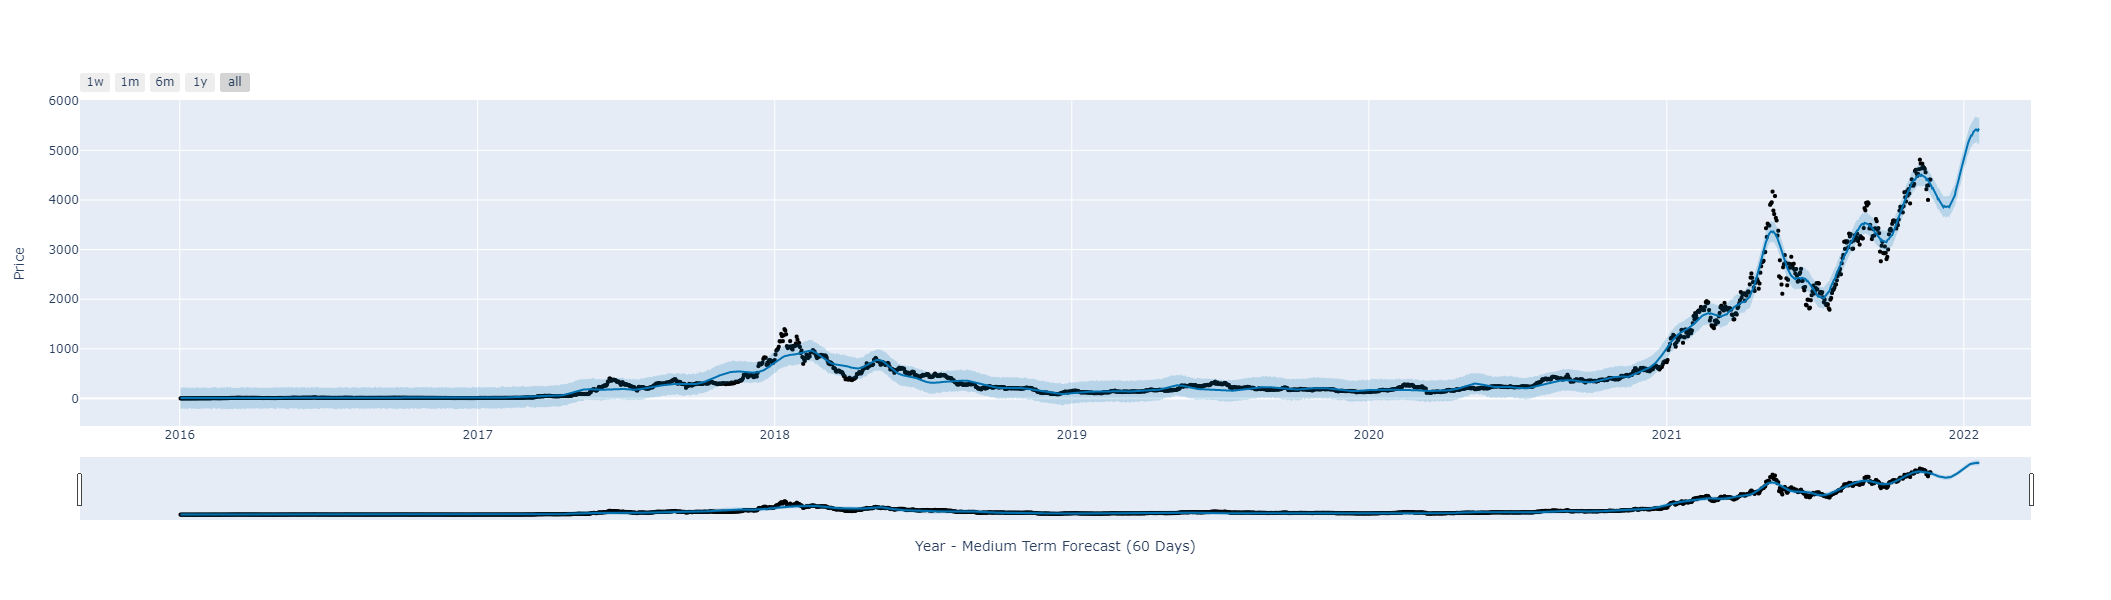

In [24]:
#Plot 60 day forecast (using Prohpet library 'plot_plotly' method)
long_plot = plot_plotly(tuned_prophet, tuned_forecast,
                       xlabel = 'Year - Medium Term Forecast (60 Days) ',
                       ylabel = 'Price')
long_plot

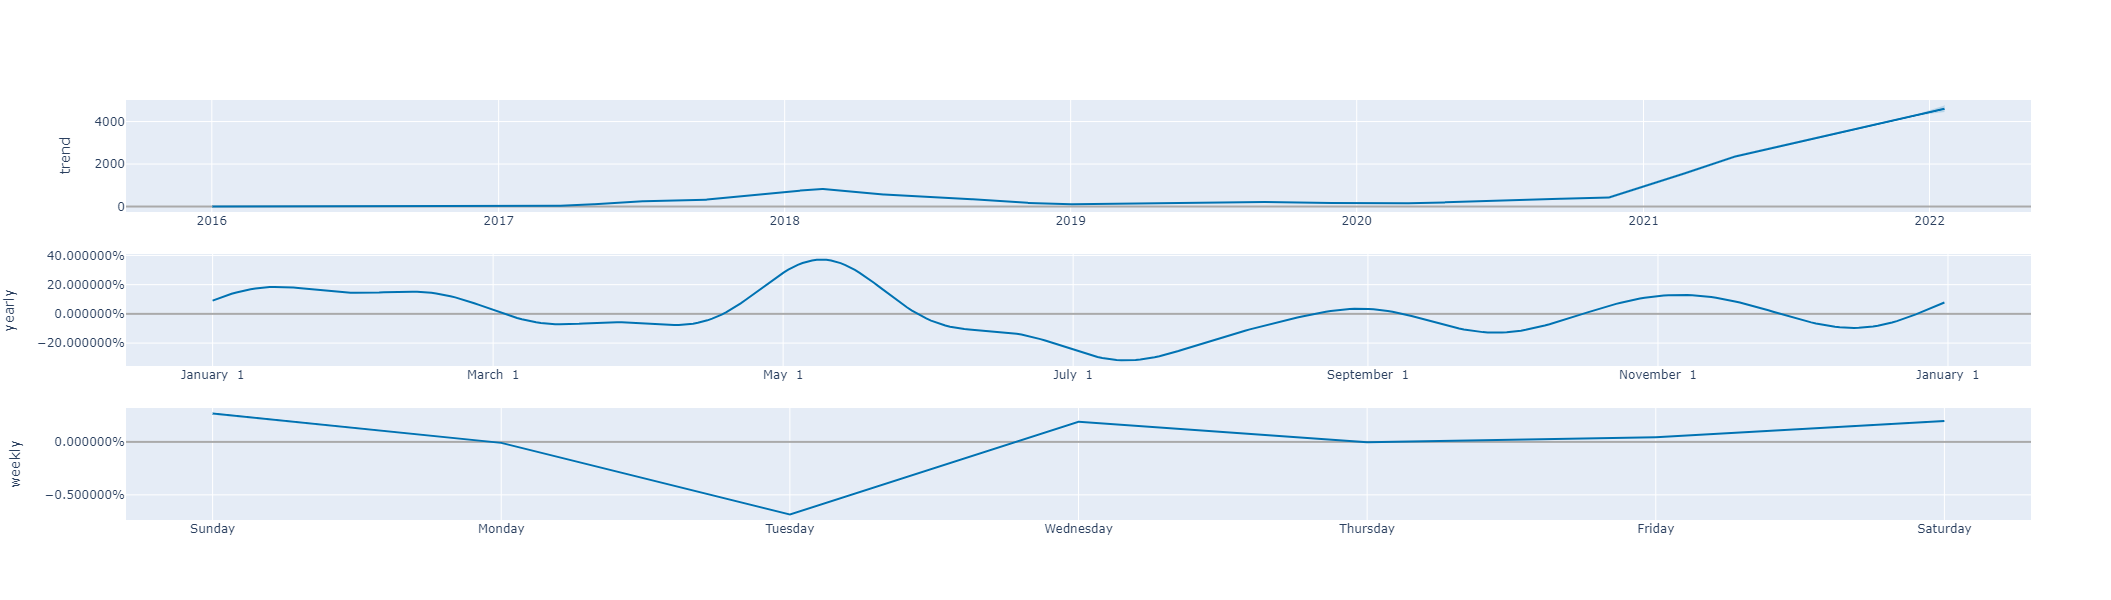

In [25]:
#Plot components for tuned model (using Prophet library 'plot_components_plotly' method)
components_plot = plot_components_plotly(tuned_prophet, tuned_forecast)
components_plot

### Cross-validate tuned model

In [26]:
#Perfrom cross-validation for the tuned model (using the Prophet library 'cross_validation' method)
tuned_df_cv = cross_validation(tuned_prophet, initial='730 days', period='30 days', horizon = '60 days')

INFO:fbprophet:Making 46 forecasts with cutoffs between 2018-01-11 00:00:00 and 2021-09-22 00:00:00


  0%|          | 0/46 [00:00<?, ?it/s]

In [27]:
#Get porformance metrics for the tuned model
tuned_df_p = performance_metrics(tuned_df_cv)

In [28]:
#Check performance metrics for the tuned model
tuned_df_p

horizon            mse        rmse         mae      mape     mdape  \
0   6 days   16766.799542  129.486677   86.617752  0.182055  0.156106   
1   7 days   19826.737965  140.807450   92.321714  0.188714  0.163717   
2   8 days   25738.634214  160.432647   99.996197  0.194736  0.165104   
3   9 days   33583.538638  183.258120  110.808944  0.202141  0.167707   
4  10 days   43453.461903  208.454940  124.192333  0.211057  0.174893   
5  11 days   55157.361443  234.856044  138.943123  0.220818  0.186436   
6  12 days   65087.572178  255.122661  151.741577  0.229800  0.197314   
7  13 days   78855.745128  280.812651  165.798277  0.238860  0.199218   
8  14 days   91819.375824  303.017121  178.544569  0.247711  0.204377   
9  15 days  102371.768251  319.955885  186.831821  0.255091  0.209546   
10 16 days  113465.947404  336.847068  193.266088  0.260818  0.208511   
11 17 days  120534.451429  347.180719  197.739107  0.266878  0.204593   
12 18 days  130240.950137  360.889111  202.914387  0.273848  0.203384   
13 19 days  141120.322206  375.659849  209.000681  0.281809  0.199234   
14 20 days  146172.489421  382.325110  211.389511  0.288840  0.191252   
15 21 days  152687.334294  390.752267  215.128020  0.296682  0.191252   
16 22 days  157079.168227  396.332144  218.942215  0.303267  0.207765   
17 23 days  165427.890089  406.728275  224.815777  0.310379  0.216109   
18 24 days  173837.089008  416.937752  229.978484  0.317133  0.219275   
19 25 days  180292.847905  424.609053  233.154214  0.326533  0.230334   
20 26 days  189207.762615  434.980186  236.189885  0.334995  0.238081   
21 27 days  199537.338515  446.696025  241.064385  0.342559  0.238081   
22 28 days  211170.238690  459.532631  247.037527  0.351523  0.242440   
23 29 days  214872.886949  463.543835  246.825095  0.355068  0.248000   
24 30 days  214069.871690  462.676854  245.044152  0.357256  0.249735   
25 31 days  212293.075745  460.752727  244.052703  0.355867  0.250878   
26 32 days  211712.769253  460.122559  245.163759  0.356813  0.253276   
27 33 days  208203.887058  456.293641  246.538083  0.358014  0.261507   
28 34 days  199929.590652  447.134869  244.358762  0.356563  0.262279   
29 35 days  196053.689352  442.779504  245.933466  0.358998  0.263819   
30 36 days  193128.202954  439.463540  248.843405  0.361360  0.262483   
31 37 days  188798.747836  434.509779  251.229381  0.363772  0.263955   
32 38 days  184435.420447  429.459451  252.871845  0.363900  0.268022   
33 39 days  178056.277099  421.967152  250.667358  0.363088  0.285430   
34 40 days  177296.239392  421.065600  252.520074  0.367096  0.295313   
35 41 days  180373.608034  424.704142  256.900712  0.370707  0.298245   
36 42 days  182619.034039  427.339483  260.305194  0.375176  0.321973   
37 43 days  186436.306409  431.782707  262.875398  0.377993  0.327297   
38 44 days  192121.092462  438.316201  266.908030  0.383892  0.327297   
39 45 days  201366.798672  448.739121  271.363525  0.389414  0.329587   
40 46 days  211383.867752  459.765014  274.430907  0.393353  0.322551   
41 47 days  218081.082403  466.991523  276.102121  0.400266  0.326330   
42 48 days  228765.764383  478.294642  280.789194  0.408387  0.330995   
43 49 days  241311.867300  491.235043  285.772186  0.418304  0.333672   
44 50 days  247133.385233  497.125120  287.615646  0.427026  0.335759   
45 51 days  251451.709438  501.449608  291.041281  0.436762  0.345271   
46 52 days  249507.889160  499.507647  293.001891  0.444047  0.359353   
47 53 days  250747.773896  500.747216  295.916485  0.450413  0.363713   
48 54 days  247700.418524  497.695106  295.304763  0.455901  0.353151   
49 55 days  242245.352649  492.184267  295.790115  0.464384  0.348800   
50 56 days  240028.931213  489.927475  295.499598  0.470698  0.344304   
51 57 days  236737.186706  486.556458  294.438782  0.475117  0.330747   
52 58 days  238454.796261  488.318335  297.164085  0.483144  0.324898   
53 59 days  237073.691114  486.902137  298.506463  0.488258  

In [29]:
#Set horizon for short-term forecast
short_term = tuned_prophet.make_future_dataframe(periods = 10)

In [30]:
##Get predicted values for the short-term forecast using the tuned model and retain required columns
short_term_forecast = tuned_prophet.predict(short_term)
short_term_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds         yhat   yhat_lower   yhat_upper
2156 2021-11-27  4145.563550  3940.448881  4367.194003
2157 2021-11-28  4117.058724  3905.122424  4330.667865
2158 2021-11-29  4074.533578  3867.349536  4294.754688
2159 2021-11-30  4016.051531  3801.020839  4222.112172
2160 2021-12-01  4023.310397  3818.818091  4230.501658

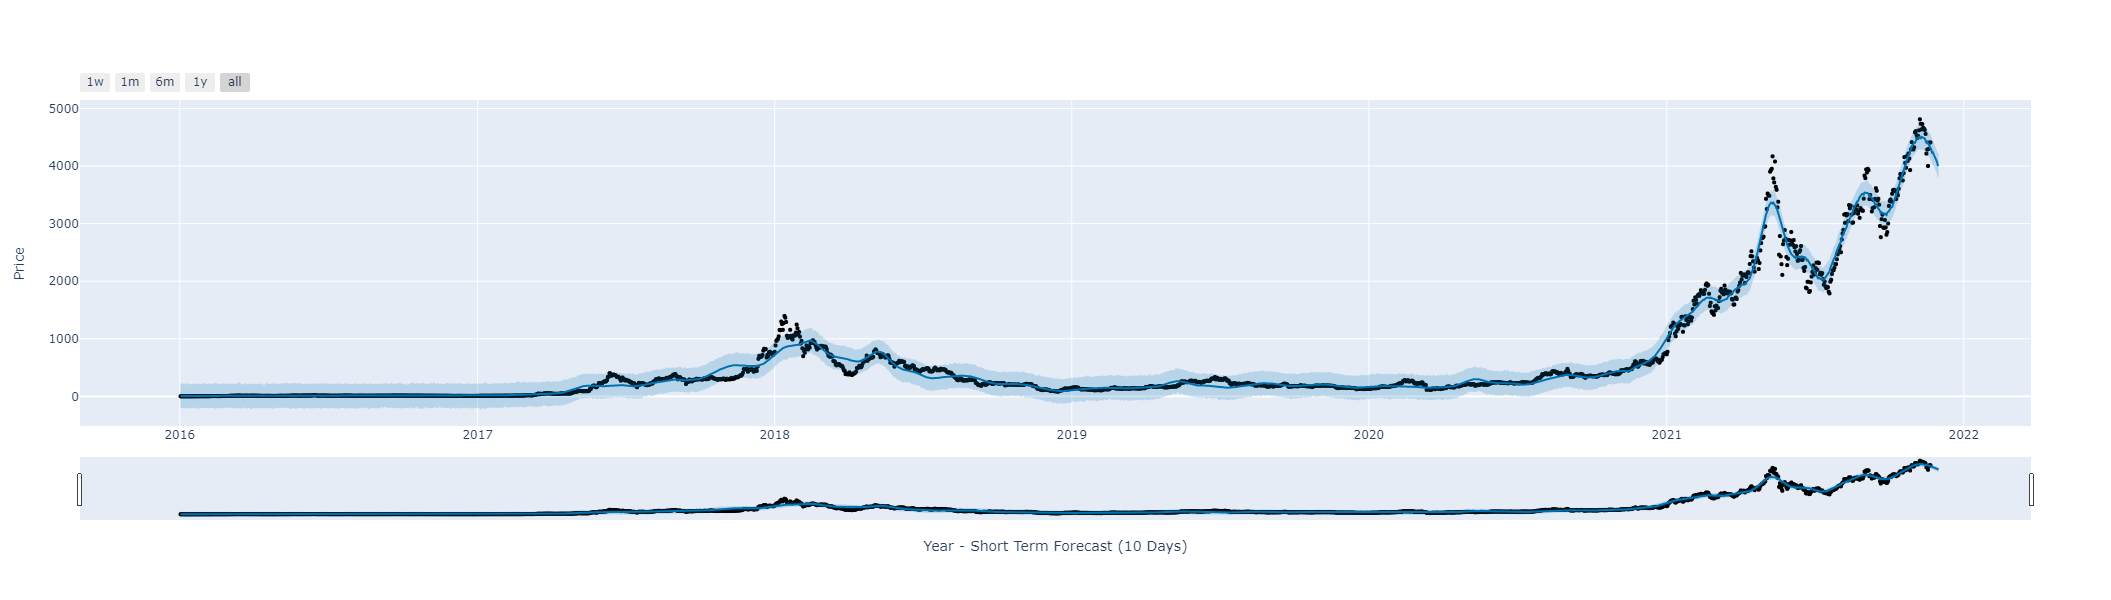

In [31]:
#Plot short-term forecast 
short_plot = plot_plotly(tuned_prophet, short_term_forecast,
                        xlabel = 'Year - Short Term Forecast (10 Days)',
                        ylabel = 'Price',
                        )
short_plot

### Create table of cross-validation metrics for users

In [32]:
#Get performance metrics of interest
forecast_outlook = tuned_df_p[['horizon', 'mae', 'mape']][:9]

In [33]:
#Rename columns
forecast_outlook = forecast_outlook.rename({'mae': '+/- Dollars (USD)', 'horizon': 'Horizon'}, axis = 1)

In [34]:
#Extrapolate an average 'accuracy score' from the average  
forecast_outlook['Accuracy (%)'] = forecast_outlook.apply(lambda row: 100 - row['mape']*100, axis = 1)

In [35]:
#Remove the 'mape' feature
forecast_outlook = forecast_outlook.drop('mape', axis = 1)

In [36]:
#Check dataframe and round results to 2 decimal places 
forecast_outlook.round(2)

Horizon  +/- Dollars (USD)  Accuracy (%)
0  6 days              86.62         81.79
1  7 days              92.32         81.13
2  8 days             100.00         80.53
3  9 days             110.81         79.79
4 10 days             124.19         78.89
5 11 days             138.94         77.92
6 12 days             151.74         77.02
7 13 days             165.80         76.11
8 14 days             178.54         75.23

### Export relevant plots and save model

In [74]:
with open('ETH_Prophet.html', 'a') as f:
    f.write(long_plot.to_html(full_html=False, include_plotlyjs='cdn')),
    f.write(short_plot.to_html(full_html=False, include_plotlyjs='cdn')),
    f.write(components_plot.to_html(full_html=False, include_plotlyjs='cdn'))  

In [76]:
with open('Pro_ETH_model.json', 'w') as f:
    json.dump(model_to_json(tuned_prophet), f)